Acknowledgement: This code was initially inspired by the lab "COMP34212_Lab2b_Keras_CNN_CIFAR_2025" before undergoing significant changes.

# Setup

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar100
from tensorflow.keras import utils
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout, SpatialDropout2D
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Input, Add
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.callbacks import Callback, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras import backend as K


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

print('Libraries imported.')

Libraries imported.


# Data Preperation

In [ ]:



cifar100_fine_labels = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle',
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel',
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock',
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster',
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    'worm'
]

cifar100_coarse_labels = [
    'aquatic mammals', 'fish', 'flowers', 'food containers', 'fruit and vegetables',
    'household electrical devices', 'household furniture', 'insects', 'large carnivores',
    'large man-made outdoor things', 'large natural outdoor scenes', 'large omnivores and herbivores',
    'medium-sized mammals', 'non-insect invertebrates', 'people', 'reptiles', 'small mammals',
    'trees', 'vehicles 1', 'vehicles 2'
]


fine_to_coarse_mapping = {
    0: 4, 1: 1, 2: 14, 3: 8, 4: 0, 5: 6, 6: 7, 7: 7,
    8: 18, 9: 3, 10: 3, 11: 14, 12: 9, 13: 18, 14: 7, 15: 11,
    16: 3, 17: 9, 18: 7, 19: 11, 20: 6, 21: 11, 22: 5, 23: 10,
    24: 7, 25: 6, 26: 13, 27: 15, 28: 3, 29: 15, 30: 0, 31: 11,
    32: 1, 33: 10, 34: 12, 35: 14, 36: 16, 37: 9, 38: 11, 39: 5,
    40: 5, 41: 19, 42: 8, 43: 8, 44: 15, 45: 13, 46: 14, 47: 17,
    48: 18, 49: 10, 50: 16, 51: 4, 52: 17, 53: 4, 54: 2, 55: 0,
    56: 17, 57: 4, 58: 18, 59: 17, 60: 10, 61: 3, 62: 2, 63: 12,
    64: 12, 65: 16, 66: 12, 67: 1, 68: 9, 69: 19, 70: 2, 71: 10,
    72: 0, 73: 1, 74: 16, 75: 12, 76: 9, 77: 13, 78: 15, 79: 13,
    80: 16, 81: 18, 82: 2, 83: 4, 84: 6, 85: 19, 86: 5, 87: 5,
    88: 8, 89: 19, 90: 18, 91: 1, 92: 2, 93: 15, 94: 6, 95: 0,
    96: 17, 97: 8, 98: 14, 99: 13
}

In [ ]:

BATCH_SIZE = 256
N_EPOCH = 75
N_CLASSES = 100
N_SUPERCLASSES = 20
VERBOSE = 1
VALIDATION_SPLIT = 0.2

print('Main variables initialised.')


IMG_CHANNELS = 3
IMG_ROWS = 32
IMG_COLS = 32

print('Image variables initialisation')


Main variables initialised.
Image variables initialisation


In [ ]:

(input_X_train, output_y_train), (input_X_test, output_y_test) = cifar100.load_data(label_mode='fine')
print('input_X_train shape:', input_X_train.shape)
print(input_X_train.shape[0], 'train samples')
print(input_X_test.shape[0], 'test samples')


output_Y_train = utils.to_categorical(output_y_train, N_CLASSES)
output_Y_test = utils.to_categorical(output_y_test, N_CLASSES)


input_X_train = input_X_train.astype('float32')
input_X_test = input_X_test.astype('float32')
input_X_train /= 255
input_X_test /= 255


169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step
input_X_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


Sample input image class: apple


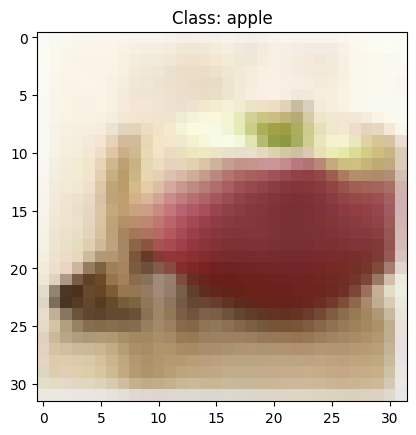

Sample input image class: boy


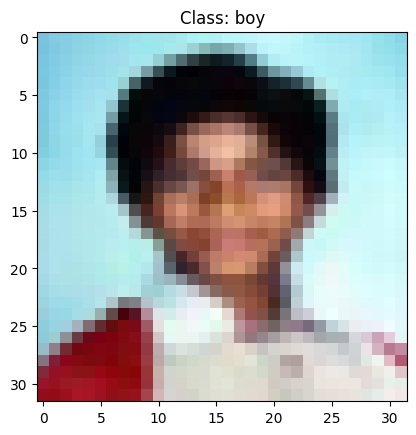

In [ ]:

Selected_Image = 2
image = input_X_train[Selected_Image]
print("Sample input image class:", cifar100_fine_labels[output_y_train[Selected_Image][0]])
plt.imshow(image)
plt.title(f"Class: {cifar100_fine_labels[output_y_train[Selected_Image][0]]}")
plt.show()

Selected_Image = 3
image = input_X_train[Selected_Image]
print("Sample input image class:", cifar100_fine_labels[output_y_train[Selected_Image][0]])
plt.imshow(image)
plt.title(f"Class: {cifar100_fine_labels[output_y_train[Selected_Image][0]]}")
plt.show()

# Training

In [ ]:
def identity_block(x, filters, dropout_rate):
    x_skip = x


    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)


    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)


    x = Add()([x, x_skip])
    x = Activation('relu')(x)
    return x


In [ ]:
def conv_block(x, filters, stride, dropout_rate):
    x_skip = x


    x = Conv2D(filters, 3, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)


    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)


    x_skip = Conv2D(filters, 1, strides=stride, padding='same')(x_skip)
    x_skip = BatchNormalization()(x_skip)

    x = Add()([x, x_skip])
    x = Activation('relu')(x)
    return x


In [ ]:

inputs = Input(shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS))


x = Conv2D(64, 3, strides=1, padding='same')(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)




x = conv_block(x, 64, stride=1, dropout_rate=0.3)
x = identity_block(x, 64, dropout_rate=0.3)


x = conv_block(x, 128, stride=2, dropout_rate=0.3)
x = identity_block(x, 128, dropout_rate=0.3)


x = conv_block(x, 256, stride=2, dropout_rate=0.3)
x = identity_block(x, 256, dropout_rate=0.3)


x = Dropout(0.2)(x)
x = GlobalAveragePooling2D()(x)
outputs = Dense(N_CLASSES, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

In [ ]:
class TrainingMonitor(Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = K.get_value(self.model.optimizer.learning_rate)
        print(f"\nEpoch {epoch+1}")
        print(f"LR: {lr:.1e}\n")
        print(f"  Training Loss: {logs['loss']:.4f} - Training Accuracy: {logs['accuracy']:.4f}")
        print(f"  Validation Loss: {logs['val_loss']:.4f} - Validation Accuracy: {logs['val_accuracy']:.4f}")
        if logs['accuracy'] - logs['val_accuracy'] > 0.15:
            print(f"! Overfitting: {logs['accuracy']-logs['val_accuracy']:.4f} gap")



In [ ]:

OPTIM1 = tf.keras.optimizers.AdamW(
    learning_rate=0.001,
    weight_decay=0.01,
    global_clipnorm=1.0,
)

model.compile(loss='categorical_crossentropy', optimizer=OPTIM1, metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 64)     │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 32, 32, 64)     │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 32, 32, 64)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 32, 32, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 32, 32, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 32, 32, 64)     │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 32, 64)     │          4,160 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 32, 32, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 32, 32, 64)     │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 32, 32, 64)     │              0 │ dropout[0][0],         │
│                           │                        │                │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 32, 32, 64)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 32, 32, 64)     │            256 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activat

 Total params: 2,811,940 (10.73 MB)

 Trainable params: 2,807,332 (10.71 MB)

 Non-trainable params: 4,608 (18.00 KB)

In [ ]:

early_stop = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=8,
    restore_best_weights=True,
    start_from_epoch=10
)

In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=4,
    min_lr=1e-6,
    mode='max',
    cooldown=1,
    verbose=1
)

In [ ]:

checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

In [ ]:
history = model.fit(
    input_X_train, output_Y_train,
    batch_size=BATCH_SIZE,
    epochs=N_EPOCH,
    validation_split=VALIDATION_SPLIT,
    verbose=VERBOSE,
    callbacks=[
        early_stop,
        checkpoint,
        TrainingMonitor(),
        reduce_lr,
    ]
)


Epoch 1/75
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.0843 - loss: 4.1068
Epoch 1: val_accuracy improved from -inf to 0.00940, saving model to best_model.h5



Epoch 1
LR: 1.0e-03

  Training Loss: 3.7413 - Training Accuracy: 0.1286
  Validation Loss: 8.0322 - Validation Accuracy: 0.0094
157/157 ━━━━━━━━━━━━━━━━━━━━ 54s 149ms/step - accuracy: 0.0845 - loss: 4.1045 - val_accuracy: 0.0094 - val_loss: 8.0322 - learning_rate: 0.0010
Epoch 2/75
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2253 - loss: 3.1333
Epoch 2: val_accuracy improved from 0.00940 to 0.03460, saving model to best_model.h5



Epoch 2
LR: 1.0e-03

  Training Loss: 2.9979 - Training Accuracy: 0.2518
  Validation Loss: 5.8835 - Validation Accuracy: 0.0346
! Overfitting: 0.2172 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.2258 - loss: 3.1307 - val_accuracy: 0.0346 - val_loss: 5.8835 - learning_rate: 0.0010
Epoch 3/75
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3230 - loss: 2.6328
Epoch 3: val_accuracy improved from 0.03460 to 0.12980, saving model to best_model.h5



Epoch 3
LR: 1.0e-03

  Training Loss: 2.5756 - Training Accuracy: 0.3353
  Validation Loss: 4.0561 - Validation Accuracy: 0.1298
! Overfitting: 0.2055 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.3232 - loss: 2.6317 - val_accuracy: 0.1298 - val_loss: 4.0561 - learning_rate: 0.0010
Epoch 4/75
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3756 - loss: 2.3616
Epoch 4: val_accuracy improved from 0.12980 to 0.23450, saving model to best_model.h5



Epoch 4
LR: 1.0e-03

  Training Loss: 2.3073 - Training Accuracy: 0.3892
  Validation Loss: 3.2505 - Validation Accuracy: 0.2345
! Overfitting: 0.1547 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.3758 - loss: 2.3606 - val_accuracy: 0.2345 - val_loss: 3.2505 - learning_rate: 0.0010
Epoch 5/75
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4370 - loss: 2.0911
Epoch 5: val_accuracy improved from 0.23450 to 0.32470, saving model to best_model.h5



Epoch 5
LR: 1.0e-03

  Training Loss: 2.0919 - Training Accuracy: 0.4373
  Validation Loss: 2.7256 - Validation Accuracy: 0.3247
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.4371 - loss: 2.0911 - val_accuracy: 0.3247 - val_loss: 2.7256 - learning_rate: 0.0010
Epoch 6/75
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4664 - loss: 1.9585
Epoch 6: val_accuracy improved from 0.32470 to 0.33600, saving model to best_model.h5



Epoch 6
LR: 1.0e-03

  Training Loss: 1.9358 - Training Accuracy: 0.4719
  Validation Loss: 2.7031 - Validation Accuracy: 0.3360
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.4665 - loss: 1.9581 - val_accuracy: 0.3360 - val_loss: 2.7031 - learning_rate: 0.0010
Epoch 7/75
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5206 - loss: 1.7532
Epoch 7: val_accuracy did not improve from 0.33600

Epoch 7
LR: 1.0e-03

  Training Loss: 1.7552 - Training Accuracy: 0.5162
  Validation Loss: 3.1992 - Validation Accuracy: 0.2772
! Overfitting: 0.2390 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.5205 - loss: 1.7532 - val_accuracy: 0.2772 - val_loss: 3.1992 - learning_rate: 0.0010
Epoch 8/75
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5480 - loss: 1.6264
Epoch 8: val_accuracy improved from 0.33600 to 0.37300, saving model to best_model.h5



Epoch 8
LR: 1.0e-03

  Training Loss: 1.6330 - Training Accuracy: 0.5447
  Validation Loss: 2.6050 - Validation Accuracy: 0.3730
! Overfitting: 0.1717 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.5479 - loss: 1.6266 - val_accuracy: 0.3730 - val_loss: 2.6050 - learning_rate: 0.0010
Epoch 9/75
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5805 - loss: 1.4918
Epoch 9: val_accuracy did not improve from 0.37300

Epoch 9
LR: 1.0e-03

  Training Loss: 1.5013 - Training Accuracy: 0.5803
  Validation Loss: 3.0371 - Validation Accuracy: 0.3050
! Overfitting: 0.2753 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.5805 - loss: 1.4919 - val_accuracy: 0.3050 - val_loss: 3.0371 - learning_rate: 0.0010
Epoch 10/75
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6225 - loss: 1.3375
Epoch 10: val_accuracy improved from 0.37300 to 0.46260, saving model to best_model.h5



Epoch 10
LR: 1.0e-03

  Training Loss: 1.3735 - Training Accuracy: 0.6119
  Validation Loss: 2.1132 - Validation Accuracy: 0.4626
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.6223 - loss: 1.3382 - val_accuracy: 0.4626 - val_loss: 2.1132 - learning_rate: 0.0010
Epoch 11/75
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6358 - loss: 1.2770
Epoch 11: val_accuracy improved from 0.46260 to 0.47720, saving model to best_model.h5



Epoch 11
LR: 1.0e-03

  Training Loss: 1.2749 - Training Accuracy: 0.6343
  Validation Loss: 2.0715 - Validation Accuracy: 0.4772
! Overfitting: 0.1571 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.6358 - loss: 1.2769 - val_accuracy: 0.4772 - val_loss: 2.0715 - learning_rate: 0.0010
Epoch 12/75
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6653 - loss: 1.1486
Epoch 12: val_accuracy did not improve from 0.47720

Epoch 12
LR: 1.0e-03

  Training Loss: 1.1675 - Training Accuracy: 0.6610
  Validation Loss: 2.1436 - Validation Accuracy: 0.4584
! Overfitting: 0.2026 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.6652 - loss: 1.1489 - val_accuracy: 0.4584 - val_loss: 2.1436 - learning_rate: 0.0010
Epoch 13/75
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6922 - loss: 1.0524
Epoch 13: val_accuracy did not improve from 0.47720

Epoch 13
LR: 1.0e-03

  Training Loss: 1.0779 - Training Accuracy: 0.6838
  Validation Loss: 2.0784 - Validation Accuracy


Epoch 14
LR: 1.0e-03

  Training Loss: 0.9689 - Training Accuracy: 0.7168
  Validation Loss: 1.8706 - Validation Accuracy: 0.5169
! Overfitting: 0.1999 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.7238 - loss: 0.9438 - val_accuracy: 0.5169 - val_loss: 1.8706 - learning_rate: 0.0010
Epoch 15/75
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7406 - loss: 0.8703
Epoch 15: val_accuracy improved from 0.51690 to 0.51940, saving model to best_model.h5



Epoch 15
LR: 1.0e-03

  Training Loss: 0.8892 - Training Accuracy: 0.7338
  Validation Loss: 1.9171 - Validation Accuracy: 0.5194
! Overfitting: 0.2144 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.7405 - loss: 0.8707 - val_accuracy: 0.5194 - val_loss: 1.9171 - learning_rate: 0.0010
Epoch 16/75
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7656 - loss: 0.7927
Epoch 16: val_accuracy did not improve from 0.51940

Epoch 16
LR: 1.0e-03

  Training Loss: 0.8125 - Training Accuracy: 0.7571
  Validation Loss: 1.9259 - Validation Accuracy: 0.5192
! Overfitting: 0.2379 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.7654 - loss: 0.7929 - val_accuracy: 0.5192 - val_loss: 1.9259 - learning_rate: 0.0010
Epoch 17/75
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7873 - loss: 0.7081
Epoch 17: val_accuracy improved from 0.51940 to 0.52510, saving model to best_model.h5



Epoch 17
LR: 1.0e-03

  Training Loss: 0.7363 - Training Accuracy: 0.7765
  Validation Loss: 1.9853 - Validation Accuracy: 0.5251
! Overfitting: 0.2514 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.7872 - loss: 0.7085 - val_accuracy: 0.5251 - val_loss: 1.9853 - learning_rate: 0.0010
Epoch 18/75
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8094 - loss: 0.6313
Epoch 18: val_accuracy did not improve from 0.52510

Epoch 18
LR: 1.0e-03

  Training Loss: 0.6533 - Training Accuracy: 0.8015
  Validation Loss: 2.2051 - Validation Accuracy: 0.5065
! Overfitting: 0.2950 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.8093 - loss: 0.6316 - val_accuracy: 0.5065 - val_loss: 2.2051 - learning_rate: 0.0010
Epoch 19/75
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8258 - loss: 0.5676
Epoch 19: val_accuracy did not improve from 0.52510

Epoch 19
LR: 1.0e-03

  Training Loss: 0.5917 - Training Accuracy: 0.8192
  Validation Loss: 2.1347 - Validation Accuracy


Epoch 22
LR: 5.0e-04

  Training Loss: 0.2904 - Training Accuracy: 0.9183
  Validation Loss: 1.7098 - Validation Accuracy: 0.5928
! Overfitting: 0.3255 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9145 - loss: 0.3028 - val_accuracy: 0.5928 - val_loss: 1.7098 - learning_rate: 5.0000e-04
Epoch 23/75
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9428 - loss: 0.2222
Epoch 23: val_accuracy did not improve from 0.59280

Epoch 23
LR: 5.0e-04

  Training Loss: 0.2293 - Training Accuracy: 0.9402
  Validation Loss: 1.7788 - Validation Accuracy: 0.5864
! Overfitting: 0.3538 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.9428 - loss: 0.2224 - val_accuracy: 0.5864 - val_loss: 1.7788 - learning_rate: 5.0000e-04
Epoch 24/75
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9544 - loss: 0.1851
Epoch 24: val_accuracy improved from 0.59280 to 0.59580, saving model to best_model.h5



Epoch 24
LR: 5.0e-04

  Training Loss: 0.1962 - Training Accuracy: 0.9488
  Validation Loss: 1.7372 - Validation Accuracy: 0.5958
! Overfitting: 0.3530 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9543 - loss: 0.1852 - val_accuracy: 0.5958 - val_loss: 1.7372 - learning_rate: 5.0000e-04
Epoch 25/75
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9611 - loss: 0.1622
Epoch 25: val_accuracy improved from 0.59580 to 0.59910, saving model to best_model.h5



Epoch 25
LR: 5.0e-04

  Training Loss: 0.1727 - Training Accuracy: 0.9567
  Validation Loss: 1.7960 - Validation Accuracy: 0.5991
! Overfitting: 0.3576 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9611 - loss: 0.1623 - val_accuracy: 0.5991 - val_loss: 1.7960 - learning_rate: 5.0000e-04
Epoch 26/75
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9660 - loss: 0.1429
Epoch 26: val_accuracy did not improve from 0.59910

Epoch 26
LR: 5.0e-04

  Training Loss: 0.1537 - Training Accuracy: 0.9612
  Validation Loss: 1.8267 - Validation Accuracy: 0.5931
! Overfitting: 0.3681 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.9659 - loss: 0.1431 - val_accuracy: 0.5931 - val_loss: 1.8267 - learning_rate: 5.0000e-04
Epoch 27/75
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9704 - loss: 0.1283
Epoch 27: val_accuracy did not improve from 0.59910

Epoch 27
LR: 5.0e-04

  Training Loss: 0.1348 - Training Accuracy: 0.9674
  Validation Loss: 1.9563 - Validation 


Epoch 28
LR: 5.0e-04

  Training Loss: 0.1264 - Training Accuracy: 0.9683
  Validation Loss: 1.8941 - Validation Accuracy: 0.6028
! Overfitting: 0.3655 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.9715 - loss: 0.1185 - val_accuracy: 0.6028 - val_loss: 1.8941 - learning_rate: 5.0000e-04
Epoch 29/75
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9735 - loss: 0.1100
Epoch 29: val_accuracy did not improve from 0.60280

Epoch 29
LR: 5.0e-04

  Training Loss: 0.1160 - Training Accuracy: 0.9719
  Validation Loss: 1.9794 - Validation Accuracy: 0.5949
! Overfitting: 0.3770 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.9735 - loss: 0.1101 - val_accuracy: 0.5949 - val_loss: 1.9794 - learning_rate: 5.0000e-04
Epoch 30/75
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9770 - loss: 0.0985
Epoch 30: val_accuracy did not improve from 0.60280

Epoch 30
LR: 5.0e-04

  Training Loss: 0.1026 - Training Accuracy: 0.9758
  Validation Loss: 1.9945 - Validation 


Epoch 33
LR: 2.5e-04

  Training Loss: 0.0528 - Training Accuracy: 0.9907
  Validation Loss: 1.8547 - Validation Accuracy: 0.6221
! Overfitting: 0.3686 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9889 - loss: 0.0580 - val_accuracy: 0.6221 - val_loss: 1.8547 - learning_rate: 2.5000e-04
Epoch 34/75
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9940 - loss: 0.0406
Epoch 34: val_accuracy improved from 0.62210 to 0.63160, saving model to best_model.h5



Epoch 34
LR: 2.5e-04

  Training Loss: 0.0417 - Training Accuracy: 0.9934
  Validation Loss: 1.8083 - Validation Accuracy: 0.6316
! Overfitting: 0.3618 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.9940 - loss: 0.0406 - val_accuracy: 0.6316 - val_loss: 1.8083 - learning_rate: 2.5000e-04
Epoch 35/75
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9949 - loss: 0.0344
Epoch 35: val_accuracy did not improve from 0.63160

Epoch 35
LR: 2.5e-04

  Training Loss: 0.0352 - Training Accuracy: 0.9949
  Validation Loss: 1.8464 - Validation Accuracy: 0.6286
! Overfitting: 0.3663 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9949 - loss: 0.0344 - val_accuracy: 0.6286 - val_loss: 1.8464 - learning_rate: 2.5000e-04
Epoch 36/75
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9956 - loss: 0.0324
Epoch 36: val_accuracy did not improve from 0.63160

Epoch 36
LR: 2.5e-04

  Training Loss: 0.0331 - Training Accuracy: 0.9953
  Validation Loss: 1.9783 - Validation 


Epoch 39
LR: 1.3e-04

  Training Loss: 0.0203 - Training Accuracy: 0.9977
  Validation Loss: 1.8488 - Validation Accuracy: 0.6403
! Overfitting: 0.3574 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.9970 - loss: 0.0219 - val_accuracy: 0.6403 - val_loss: 1.8488 - learning_rate: 1.2500e-04
Epoch 40/75
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9986 - loss: 0.0174
Epoch 40: val_accuracy improved from 0.64030 to 0.64280, saving model to best_model.h5



Epoch 40
LR: 1.3e-04

  Training Loss: 0.0173 - Training Accuracy: 0.9987
  Validation Loss: 1.8554 - Validation Accuracy: 0.6428
! Overfitting: 0.3559 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9986 - loss: 0.0174 - val_accuracy: 0.6428 - val_loss: 1.8554 - learning_rate: 1.2500e-04
Epoch 41/75
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9985 - loss: 0.0164
Epoch 41: val_accuracy did not improve from 0.64280

Epoch 41
LR: 1.3e-04

  Training Loss: 0.0170 - Training Accuracy: 0.9984
  Validation Loss: 1.8900 - Validation Accuracy: 0.6376
! Overfitting: 0.3608 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.9985 - loss: 0.0164 - val_accuracy: 0.6376 - val_loss: 1.8900 - learning_rate: 1.2500e-04
Epoch 42/75
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9991 - loss: 0.0141
Epoch 42: val_accuracy improved from 0.64280 to 0.64580, saving model to best_model.h5



Epoch 42
LR: 1.3e-04

  Training Loss: 0.0150 - Training Accuracy: 0.9988
  Validation Loss: 1.8391 - Validation Accuracy: 0.6458
! Overfitting: 0.3530 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9991 - loss: 0.0141 - val_accuracy: 0.6458 - val_loss: 1.8391 - learning_rate: 1.2500e-04
Epoch 43/75
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9989 - loss: 0.0140
Epoch 43: val_accuracy improved from 0.64580 to 0.64640, saving model to best_model.h5



Epoch 43
LR: 1.3e-04

  Training Loss: 0.0141 - Training Accuracy: 0.9988
  Validation Loss: 1.8514 - Validation Accuracy: 0.6464
! Overfitting: 0.3524 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9989 - loss: 0.0140 - val_accuracy: 0.6464 - val_loss: 1.8514 - learning_rate: 1.2500e-04
Epoch 44/75
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9984 - loss: 0.0139
Epoch 44: val_accuracy did not improve from 0.64640

Epoch 44
LR: 1.3e-04

  Training Loss: 0.0143 - Training Accuracy: 0.9988
  Validation Loss: 1.9203 - Validation Accuracy: 0.6417
! Overfitting: 0.3571 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.9984 - loss: 0.0139 - val_accuracy: 0.6417 - val_loss: 1.9203 - learning_rate: 1.2500e-04
Epoch 45/75
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9993 - loss: 0.0132
Epoch 45: val_accuracy did not improve from 0.64640

Epoch 45
LR: 1.3e-04

  Training Loss: 0.0132 - Training Accuracy: 0.9990
  Validation Loss: 1.8887 - Validation 


Epoch 48
LR: 6.3e-05

  Training Loss: 0.0119 - Training Accuracy: 0.9990
  Validation Loss: 1.8969 - Validation Accuracy: 0.6482
! Overfitting: 0.3508 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9989 - loss: 0.0124 - val_accuracy: 0.6482 - val_loss: 1.8969 - learning_rate: 6.2500e-05
Epoch 49/75
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9991 - loss: 0.0105
Epoch 49: val_accuracy improved from 0.64820 to 0.65050, saving model to best_model.h5



Epoch 49
LR: 6.3e-05

  Training Loss: 0.0105 - Training Accuracy: 0.9991
  Validation Loss: 1.8850 - Validation Accuracy: 0.6505
! Overfitting: 0.3486 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9991 - loss: 0.0105 - val_accuracy: 0.6505 - val_loss: 1.8850 - learning_rate: 6.2500e-05
Epoch 50/75
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9996 - loss: 0.0099
Epoch 50: val_accuracy did not improve from 0.65050

Epoch 50
LR: 6.3e-05

  Training Loss: 0.0100 - Training Accuracy: 0.9995
  Validation Loss: 1.8835 - Validation Accuracy: 0.6500
! Overfitting: 0.3495 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9996 - loss: 0.0099 - val_accuracy: 0.6500 - val_loss: 1.8835 - learning_rate: 6.2500e-05
Epoch 51/75
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9994 - loss: 0.0094
Epoch 51: val_accuracy did not improve from 0.65050

Epoch 51
LR: 6.3e-05

  Training Loss: 0.0098 - Training Accuracy: 0.9992
  Validation Loss: 1.8733 - Validation 


Epoch 55
LR: 3.1e-05

  Training Loss: 0.0087 - Training Accuracy: 0.9993
  Validation Loss: 1.8908 - Validation Accuracy: 0.6523
! Overfitting: 0.3470 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9993 - loss: 0.0088 - val_accuracy: 0.6523 - val_loss: 1.8908 - learning_rate: 3.1250e-05
Epoch 56/75
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9994 - loss: 0.0083
Epoch 56: val_accuracy did not improve from 0.65230

Epoch 56
LR: 3.1e-05

  Training Loss: 0.0080 - Training Accuracy: 0.9995
  Validation Loss: 1.9020 - Validation Accuracy: 0.6511
! Overfitting: 0.3484 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.9994 - loss: 0.0083 - val_accuracy: 0.6511 - val_loss: 1.9020 - learning_rate: 3.1250e-05
Epoch 57/75
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9995 - loss: 0.0077
Epoch 57: val_accuracy did not improve from 0.65230

Epoch 57
LR: 3.1e-05

  Training Loss: 0.0079 - Training Accuracy: 0.9995
  Validation Loss: 1.9274 - Validation 


Epoch 63
LR: 1.6e-05

  Training Loss: 0.0070 - Training Accuracy: 0.9996
  Validation Loss: 1.8991 - Validation Accuracy: 0.6524
! Overfitting: 0.3472 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9996 - loss: 0.0068 - val_accuracy: 0.6524 - val_loss: 1.8991 - learning_rate: 1.5625e-05
Epoch 64/75
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9997 - loss: 0.0068
Epoch 64: val_accuracy did not improve from 0.65240

Epoch 64
LR: 1.6e-05

  Training Loss: 0.0069 - Training Accuracy: 0.9996
  Validation Loss: 1.9055 - Validation Accuracy: 0.6513
! Overfitting: 0.3483 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9997 - loss: 0.0068 - val_accuracy: 0.6513 - val_loss: 1.9055 - learning_rate: 1.5625e-05
Epoch 65/75
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9998 - loss: 0.0066
Epoch 65: val_accuracy did not improve from 0.65240

Epoch 65
LR: 1.6e-05

  Training Loss: 0.0067 - Training Accuracy: 0.9997
  Validation Loss: 1.9138 - Validation 

In [ ]:

predictions = model.predict(input_X_test)
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(output_Y_test, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step


## Evaluation

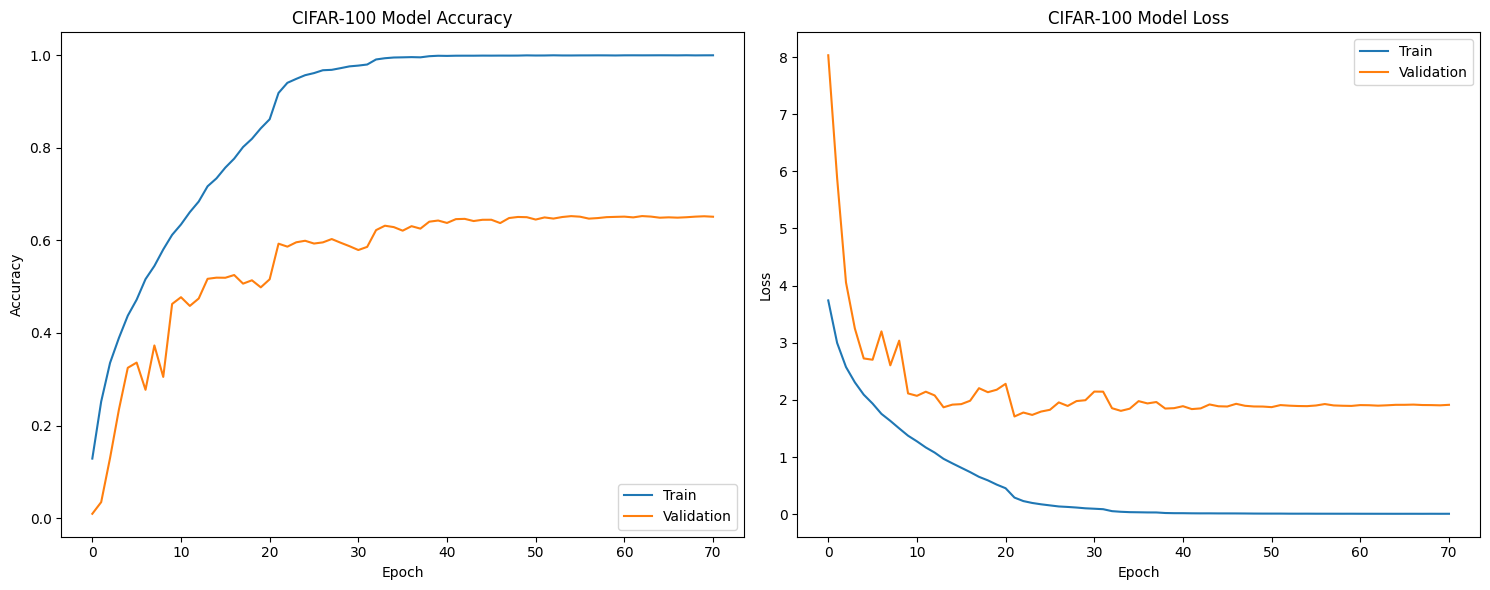

In [ ]:


plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CIFAR-100 Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CIFAR-100 Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:


test_loss, test_accuracy = model.evaluate(input_X_test, output_Y_test, verbose=VERBOSE)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


superclass_y_true = np.array([fine_to_coarse_mapping[y] for y in y_true])
superclass_y_pred = np.array([fine_to_coarse_mapping[y] for y in y_pred])

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6509 - loss: 1.9026

Test Loss: 1.8938
Test Accuracy: 0.6504


In [ ]:


precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average=None, zero_division=0)


superclass_precision, superclass_recall, superclass_f1, superclass_support = precision_recall_fscore_support(
    superclass_y_true, superclass_y_pred, average=None, labels=range(N_SUPERCLASSES), zero_division=0
)


class_metrics_df = pd.DataFrame({
    'Class': cifar100_fine_labels,
    'Superclass': [cifar100_coarse_labels[fine_to_coarse_mapping[i]] for i in range(len(cifar100_fine_labels))],
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
})


superclass_metrics_df = pd.DataFrame({
    'Superclass': cifar100_coarse_labels,
    'Precision': superclass_precision,
    'Recall': superclass_recall,
    'F1-Score': superclass_f1,
    'Support': superclass_support
})


macro_precision = np.mean(precision)
macro_recall = np.mean(recall)
macro_f1 = np.mean(f1)

print("\n=== Macro-averaged Metrics ===")
print(f"Precision: {macro_precision:.4f}")
print(f"Recall: {macro_recall:.4f}")
print(f"F1-Score: {macro_f1:.4f}")


=== Macro-averaged Metrics ===
Precision: 0.6531
Recall: 0.6504
F1-Score: 0.6477


In [ ]:

print("\n=== Superclass Performance ===")
print(superclass_metrics_df.sort_values(by='F1-Score', ascending=False))


=== Superclass Performance ===
                        Superclass  Precision    Recall  F1-Score  Support
17                           trees   0.905325  0.918000  0.911619      500
2                          flowers   0.861538  0.896000  0.878431      500
10    large natural outdoor scenes   0.863821  0.850000  0.856855      500
4             fruit and vegetables   0.853955  0.842000  0.847936      500
18                      vehicles 1   0.826156  0.863333  0.844336      600
9    large man-made outdoor things   0.815891  0.842000  0.828740      500
6              household furniture   0.835443  0.792000  0.813142      500
14                          people   0.836864  0.790000  0.812757      500
19                      vehicles 2   0.792500  0.792500  0.792500      400
3                  food containers   0.716783  0.820000  0.764925      500
7                          insects   0.789588  0.728000  0.757544      500
5     household electrical devices   0.764211  0.726000  0.744615   